# Segmenting brightfield images of HP1 phase droplets

This notebook walks through how we segment the brightfield images of HP1$\alpha$ phase separated material. Provided with this notebook are a few images that exhibit the major issues we encountered while building this algorithm. This notebook describes how we decided to deal with those issues and arrived at our final version of the algorithm. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from skimage.external.tifffile import imread, imsave
from skimage.feature import canny
from skimage.measure import regionprops,find_contours
from skimage.draw import circle

from scipy import ndimage as ndi
from scipy import fftpack
from scipy.ndimage.filters import convolve
from scipy.ndimage import distance_transform_edt

from smtools.point_fitting import find_maxima

import os
import time
#-- this is here to suppress the warning about regionprops.coords
#-- switching to r,c coords instead of x,y.
import warnings
warnings.filterwarnings("ignore")

The first thing to notice about the brightfield images we collect, is the rings of high and low intensity at the edges of the droplets. Additionally, the background intensity is effectively the same as the intensity inside of the droplets. This makes using basic threshold segmentation fairly terrible. To develop our method, we started from the great examples [here](http://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html), but modified it a bit to better serve our purposes and to make the process as hands-off as possble.

As a starting point, we are just using the [canny edge detector](http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html) from scikit-image, and the [binary fill holes](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.ndimage.morphology.binary_fill_holes.html) method from scipy. Below, we show the output for two different droplet images, and a two different values of sigma, which is used by the canny detector to smooth the image with a Gaussian filter before calculating the edges.

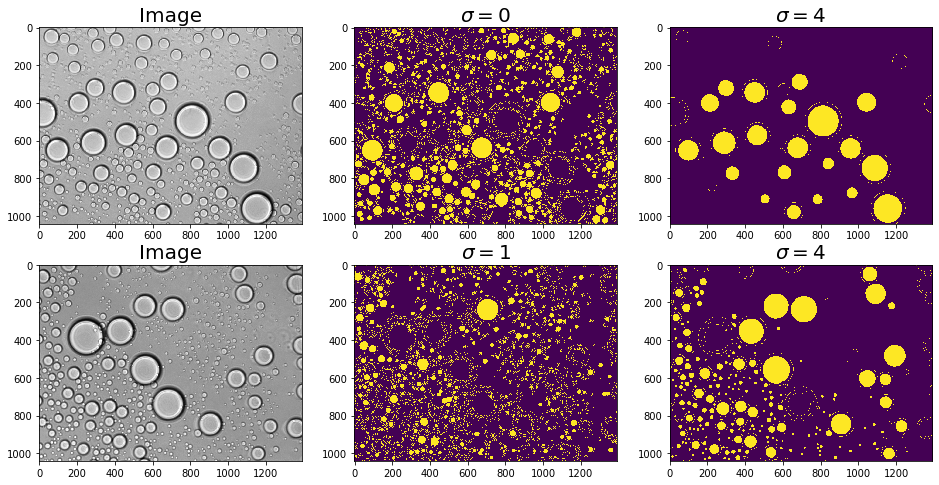

In [6]:
im = imread("test_images/test_image_1.tif")
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(231)
ax1.set_title("Image", fontsize = 20)
ax1.imshow(im, cmap = 'Greys_r')
edges = canny(im, sigma=0)
filled = ndi.binary_fill_holes(edges)
ax2 = fig.add_subplot(232)
ax2.set_title("$\sigma = 0$", fontsize = 20)
ax2.imshow(filled)
edges = canny(im, sigma=6)
filled = ndi.binary_fill_holes(edges)
ax3 = fig.add_subplot(233)
ax3.set_title("$\sigma = 4$", fontsize = 20)
ax3.imshow(filled)
    
im = imread("test_images/test_image_2.tif")
ax4 = fig.add_subplot(234)
ax4.set_title("Image", fontsize = 20)
ax4.imshow(im, cmap = 'Greys_r')
edges = canny(im, sigma=0)
filled = ndi.binary_fill_holes(edges)
ax5 = fig.add_subplot(235)
ax5.set_title("$\sigma = 1$", fontsize = 20)
ax5.imshow(filled)
edges = canny(im, sigma=4)
filled = ndi.binary_fill_holes(edges)
ax6 = fig.add_subplot(236)
ax6.set_title("$\sigma = 4$", fontsize = 20)
ax6.imshow(filled)
plt.show()

Right away, we were pretty pleased with how these looked, but there are some general issues&mdash;which largely hold true for all of our data&mdash;larger droplets are detected more readily at higher values of sigma, and smaller droplets at smaller values of sigma. This makes sense with how the detection algorithm works, but of course, we would like to detect all of the droplets if we can. There are some ways to [improve](https://en.wikipedia.org/wiki/Canny_edge_detector#Replace_Gaussian_filter) on Canny edge detection, and as a lazy way to implement adaptive smoothing, we decided to calculate the edges at a range of sigmas and then combine the images into a single detected image. 

As a side note, it's possible to pass a zero as a sigma to the canny detector, and it turns out to be useful for smaller feature sizes!

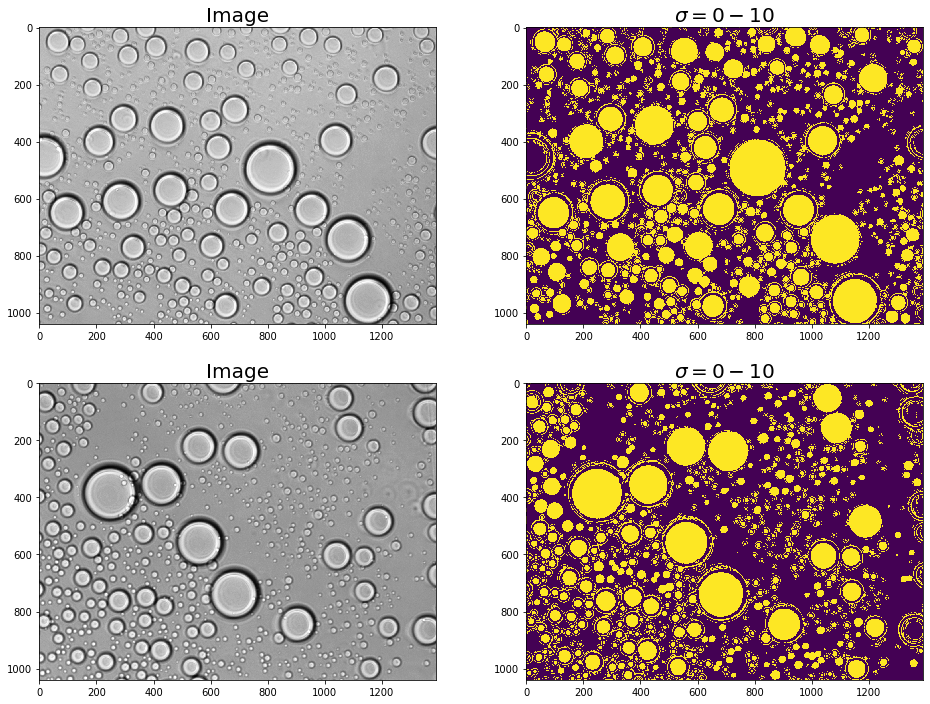

In [7]:
im = imread("test_images/test_image_1.tif")

fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(221)
ax1.set_title("Image", fontsize = 20)
ax1.imshow(im, cmap = 'Greys_r')
summed_mask = np.zeros_like(im, dtype=bool)
for i in range(11):
    edges = canny(im, sigma=i)
    filled = ndi.binary_fill_holes(edges)
    summed_mask = np.logical_or(summed_mask, filled)
ax2 = fig.add_subplot(222)
ax2.set_title("$\sigma = 0-10$", fontsize = 20)
ax2.imshow(summed_mask)

im = imread("test_images/test_image_2.tif")

ax3 = fig.add_subplot(223)
ax3.set_title("Image", fontsize = 20)
ax3.imshow(im, cmap = 'Greys_r')

summed_mask = np.zeros_like(im, dtype=bool)
for i in range(11):
    edges = canny(im, sigma=i)
    filled = ndi.binary_fill_holes(edges)
    summed_mask = np.logical_or(summed_mask, filled)
ax4 = fig.add_subplot(224)
ax4.set_title("$\sigma = 0-10$", fontsize = 20)
ax4.imshow(summed_mask)

plt.show()


On the positive side, you can see we capture most of the droplets now. However, we also pick up a fair amount of noise, which we will get no matter what, but the of course would like minimize if possible. And, more to that point, the shapes of the droplets are getting distorted quite a bit from adding all of the different masks together. But this method works pretty well and cleans up fairly well with some filtering. We will return to this method in a moment, but first we wanted to explore a few other options below.

One idea we had was to highpass filter the data in fourier space in hopes that the edge detection might be more robust. First we perform a discrete fourier transform of the image with [scipy](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.fftpack.fftn.html#scipy.fftpack.fftn),  then filter out the low frequency signal by defining radial thresholds at the "corners" of the transform.

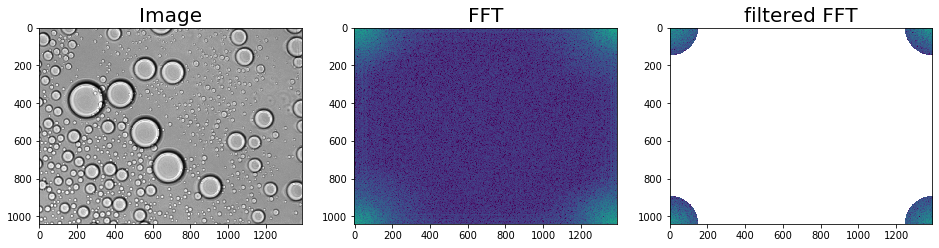

In [8]:
im = imread("test_images/test_image_2.tif")
im_fft = fftpack.fft2(im)
im_fft2 = im_fft.copy()
row, col = im_fft2.shape

#-- threshold value
radius = 150
for h in range(row):
    val1 = np.sqrt(radius**2 - h**2)
    val2 = np.sqrt(radius**2 - (h-row)**2)

    if np.isnan(val1) and np.isnan(val2):
        im_fft2[h,:] = 0    
    elif np.isnan(val2) and not np.isnan(val1):
        im_fft2[h,int(val1):col-int(val1)] = 0
    elif np.isnan(val1) and not np.isnan(val2):
        im_fft2[h,int(val2):col-int(val2)] = 0
        

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(131)
ax1.set_title("Image", fontsize = 20)
ax1.imshow(im, cmap = 'Greys_r')
ax2 = fig.add_subplot(132)
ax2.set_title("FFT", fontsize = 20)
ax2.imshow(np.abs(im_fft), norm=LogNorm(vmin=1))
ax3 = fig.add_subplot(133)
ax3.set_title("filtered FFT", fontsize = 20)
ax3.imshow(np.abs(im_fft2), norm=LogNorm(vmin=5))
plt.show()

Then we convert the image back to real space and re-run the edge detection. For some images we find a relatively small effect from filtering, but for others it has a big impact, examples of these differences are plotted below. 

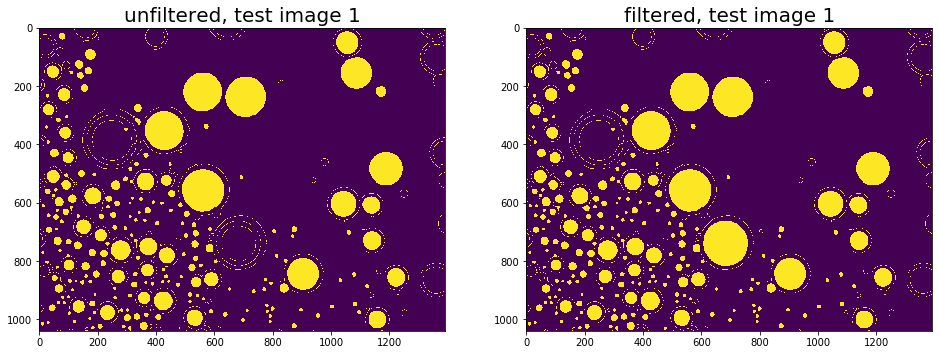

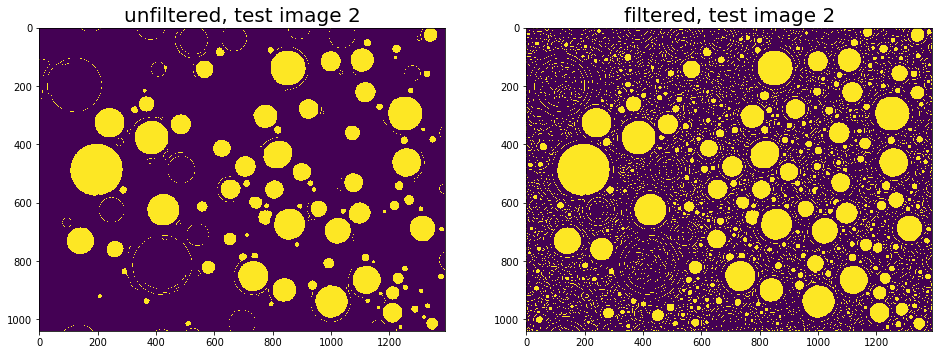

In [9]:
def highpass_fft(Image,radius):
    Image_fft = fftpack.fft2(Image)
    Image_fft2 = Image_fft.copy()
    row, col = Image_fft2.shape

    #-- threshold value
    radius = 150
    for h in range(row):
        val1 = np.sqrt(radius**2 - h**2)
        val2 = np.sqrt(radius**2 - (h-row)**2)

        if np.isnan(val1) and np.isnan(val2):
            Image_fft2[h,:] = 0    
        elif np.isnan(val2) and not np.isnan(val1):
            Image_fft2[h,int(val1):col-int(val1)] = 0
        elif np.isnan(val1) and not np.isnan(val2):
            Image_fft2[h,int(val2):col-int(val2)] = 0

    filtered_Image = fftpack.ifft2(Image_fft2).real
    
    return(filtered_Image)
    
fig = plt.figure(figsize=(16,8))

im = imread("test_images/test_image_2.tif")
edges = canny(im, 4)
filled = ndi.binary_fill_holes(edges)
ax1 = fig.add_subplot(121)
ax1.set_title("unfiltered, test image 1", fontsize = 20)
ax1.imshow(filled)

im_new = highpass_fft(im, 150)
edges = canny(im_new, 4)
filled = ndi.binary_fill_holes(edges)
ax2 = fig.add_subplot(122)
ax2.set_title("filtered, test image 1", fontsize = 20)
ax2.imshow(filled)
plt.show()


fig = plt.figure(figsize=(16,8))

im = imread("test_images/test_image_4.tif")
edges = canny(im, 4)
filled = ndi.binary_fill_holes(edges)
ax1 = fig.add_subplot(121)
ax1.set_title("unfiltered, test image 2", fontsize = 20)
ax1.imshow(filled)

im_new = highpass_fft(im, 150)
edges = canny(im_new, 4)
filled = ndi.binary_fill_holes(edges)
ax2 = fig.add_subplot(122)
ax2.set_title("filtered, test image 2", fontsize = 20)
ax2.imshow(filled)
plt.show()

From here, we also wanted to try filtering the image with a [Laplacian of Gaussian](https://en.wikipedia.org/wiki/Blob_detection#The_Laplacian_of_Gaussian) filter. To do this we generate discrete convolution kernels by a method that approximates a Laplacian of Gaussian. Below we show the dependence of the edge detection on different kernel sizes with a fixed sigma. 

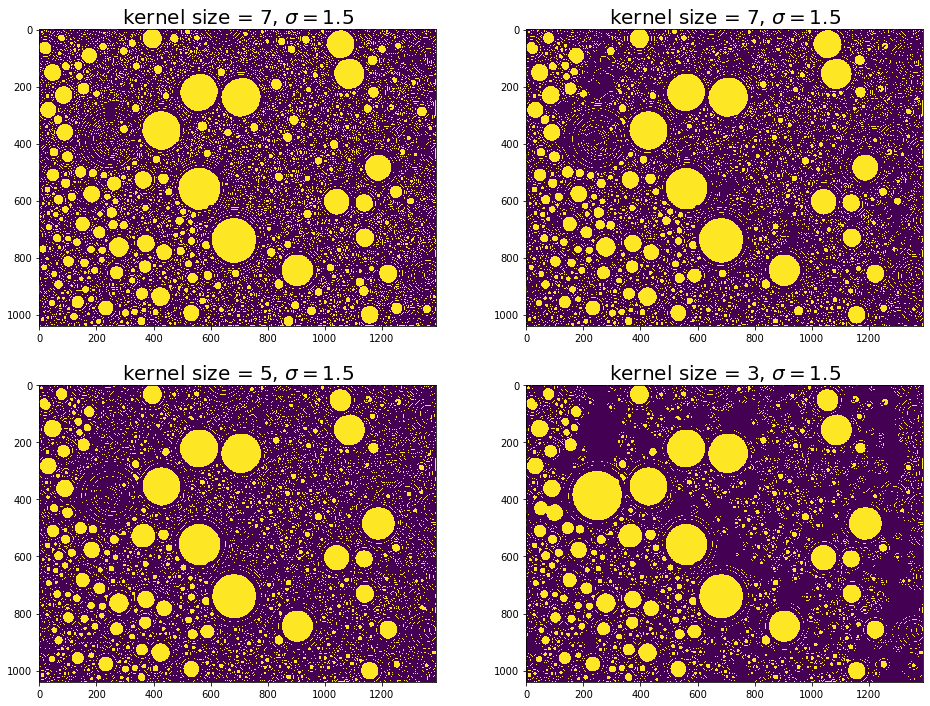

In [10]:
def LOG(x,y,sigma):
    a = (-1/(np.pi*sigma**4))
    b = (1-((x**2+y**2)/(2*sigma**2)))
    c = np.exp(-((x**2+y**2)/(2*sigma**2)))
    return(a*b*c)

def mk_LOG_kernel(size, sigma):
    k = np.zeros((size,size))
    for i in range(size):
        for j in range(size):
            k[i,j] = LOG(i-(size//2),j-(size//2),sigma)
    scaled = 1./abs(k).min()*k
    return np.rint(scaled)

im = imread("test_images/test_image_2.tif")


fig = plt.figure(figsize=(16,12))

Kernel = mk_LOG_kernel(9,1.5)
highpass_filtered = convolve(im, Kernel)
edges = canny(highpass_filtered, 4)
filled = ndi.binary_fill_holes(edges)
ax1 = fig.add_subplot(221)
ax1.set_title("kernel size = 7, $\sigma = 1.5$", fontsize = 20)
ax1.imshow(filled)

Kernel = mk_LOG_kernel(7,1.5)
highpass_filtered = convolve(im, Kernel)
edges = canny(highpass_filtered, 4)
filled = ndi.binary_fill_holes(edges)
ax1 = fig.add_subplot(222)
ax1.set_title("kernel size = 7, $\sigma = 1.5$", fontsize = 20)
ax1.imshow(filled)

Kernel = mk_LOG_kernel(5,1.5)
highpass_filtered = convolve(im, Kernel)
edges = canny(highpass_filtered, 4)
filled = ndi.binary_fill_holes(edges)
ax1 = fig.add_subplot(223)
ax1.set_title("kernel size = 5, $\sigma = 1.5$", fontsize = 20)
ax1.imshow(filled)

Kernel = mk_LOG_kernel(3,1.5)
highpass_filtered = convolve(im, Kernel)
edges = canny(highpass_filtered, 4)
filled = ndi.binary_fill_holes(edges)
ax1 = fig.add_subplot(224)
ax1.set_title("kernel size = 3, $\sigma = 1.5$", fontsize = 20)
ax1.imshow(filled)

plt.show()

So it seems the smaller filters perform better than larger, and this filtering seems to be working&mdash;i.e., it does a good job getting the image into a form that the canny detector can see both the large and small droplets. It is worth commenting on the fact that the LOG filter applies gaussian smoothing, as does the Canny detector. So it would seem plausible to just combine the smoothing into just the filter or just the detector, but this gives wildly different results than applying them seperatly, and it's not really possible to remove the gaussian step from the detector anyhow.

Below is a comparision of all three methods. Without any selection against the sizes and shapes of the detected blobs, both the summed and LOG methods seem about the same on this image in terms of efficacy. The summed method is certainly slower, however, below we show that there are more issues with the LOG method.


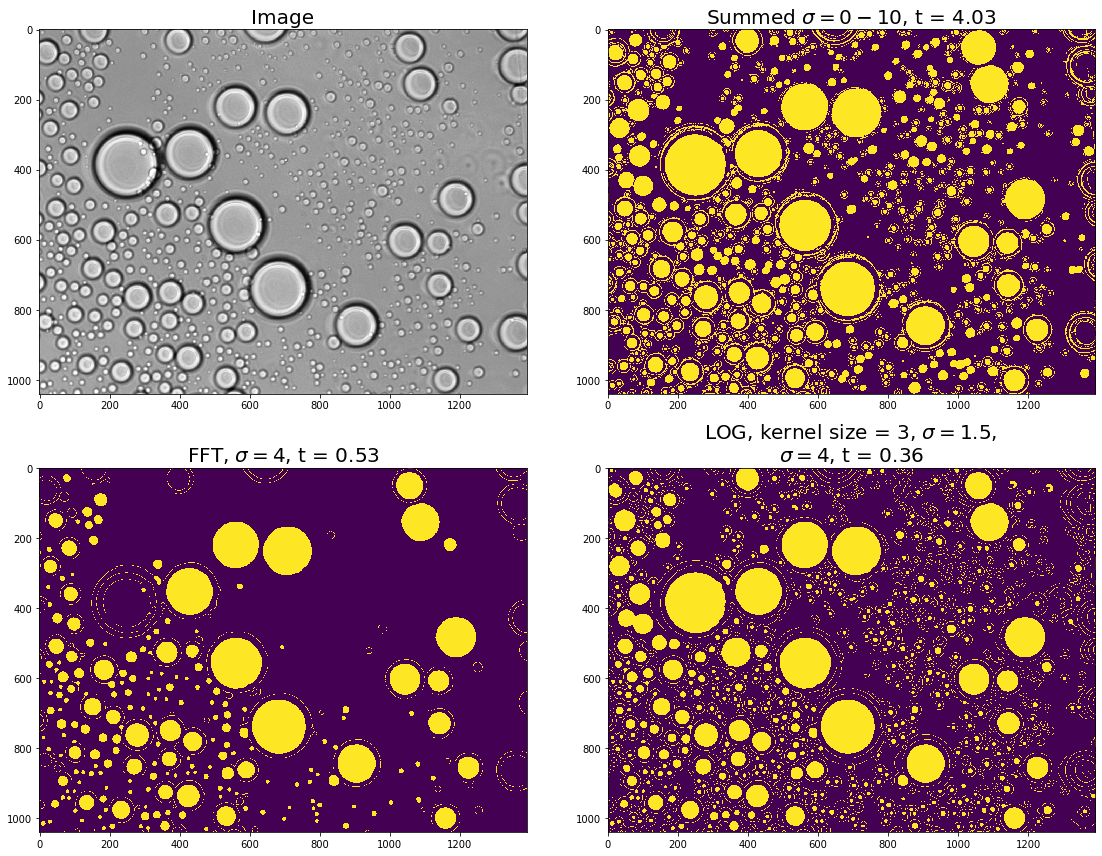

In [11]:
im = imread("test_images/test_image_2.tif")

fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax1.set_title("Image", fontsize = 20)
ax1.imshow(im, cmap = 'Greys_r')

start = time.time()
summed_mask = np.zeros_like(im, dtype=bool)
for i in range(10):
    edges = canny(im, sigma=i)
    filled = ndi.binary_fill_holes(edges)
    summed_mask = np.logical_or(summed_mask, filled)
end = time.time()
ax2 = fig.add_subplot(222)
ax2.set_title("Summed $\sigma = 0-10$, t = "+"{:.2f}".format(end - start), fontsize = 20)
ax2.imshow(summed_mask)

start = time.time()
im_new = highpass_fft(im, 150)
edges = canny(im_new, 4)
filled = ndi.binary_fill_holes(edges)
end = time.time()
ax3 = fig.add_subplot(223)
ax3.set_title("FFT, $\sigma = 4$, t = "+"{:.2f}".format(end - start), fontsize = 20)
ax3.imshow(filled)

start = time.time()
Kernel = mk_LOG_kernel(3,1.5)
highpass_filtered = convolve(im, Kernel)
edges = canny(highpass_filtered, 4)
filled = ndi.binary_fill_holes(edges)
end = time.time()
ax1 = fig.add_subplot(224)
ax1.set_title("LOG, kernel size = 3, $\sigma = 1.5$, \n$\sigma = 4$, t = "+"{:.2f}".format(end - start), 
              fontsize = 20)
ax1.imshow(filled)
plt.tight_layout()
plt.show()

There was a major issue with the LOG method, which was it pretty much didn't work on lower contrast images.

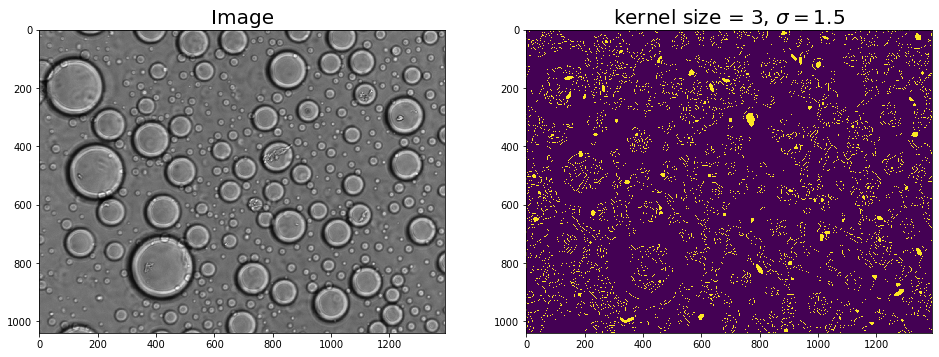

In [12]:
fig = plt.figure(figsize=(16,8))

im = imread("test_images/test_image_4.tif")

ax1 = fig.add_subplot(121)
ax1.set_title("Image", fontsize = 20)
ax1.imshow(im, cmap = "Greys_r")

Kernel = mk_LOG_kernel(3,1.5)
highpass_filtered = convolve(im, Kernel)
edges = canny(highpass_filtered, 4)
filled = ndi.binary_fill_holes(edges)
ax2 = fig.add_subplot(122)
ax2.set_title("kernel size = 3, $\sigma = 1.5$", fontsize = 20)
ax2.imshow(filled)
plt.show()

The image below highlights other differences between the two methods. The Summing method joins more of the blobs together, and also generally increases their size relative to the LOG filtering method. We can probably account for the joining phenomenon by performing [watershed segmentation](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html), but that will only work when we are in the situation above where we know that our droplets are spherical, otherwise it will break up aggregates that probably ought not be. We will return to that idea later in this notebook. As to the size difference, it's concerning that the large droplets in both methods ar roughly identical in size, but only the small droplets show the increase (or decrease, given your perspective) in size.

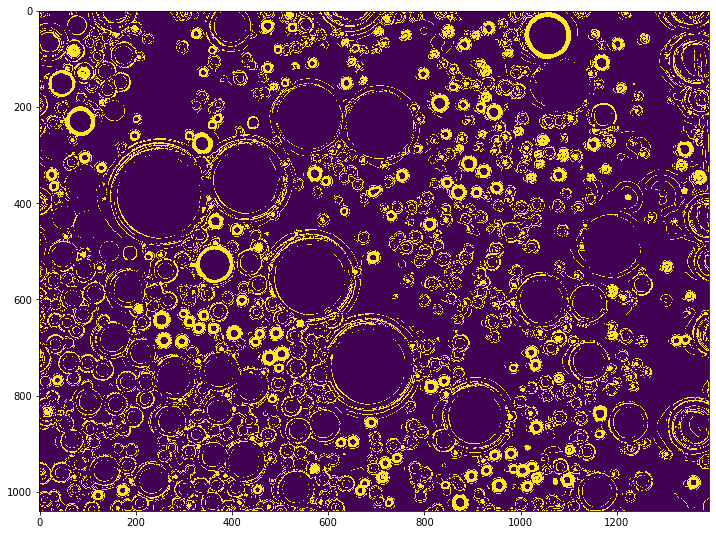

In [13]:
im = imread("test_images/test_image_2.tif")

summed_mask = np.zeros_like(im, dtype=bool)
for i in range(10):
    edges = canny(im, sigma=i)
    filled = ndi.binary_fill_holes(edges)
    summed_mask = np.logical_or(summed_mask, filled)
    
Kernel = mk_LOG_kernel(3,1.5)
highpass_filtered = convolve(im, Kernel)
edges = canny(highpass_filtered, 4)
filled = ndi.binary_fill_holes(edges)

difference = np.logical_xor(summed_mask, filled)
plt.figure(figsize=(12,12))
plt.imshow(difference)
plt.show()

To help determine which method is closer to what we might consider the ground truth, below are two zoomed in regions segmented with each method.

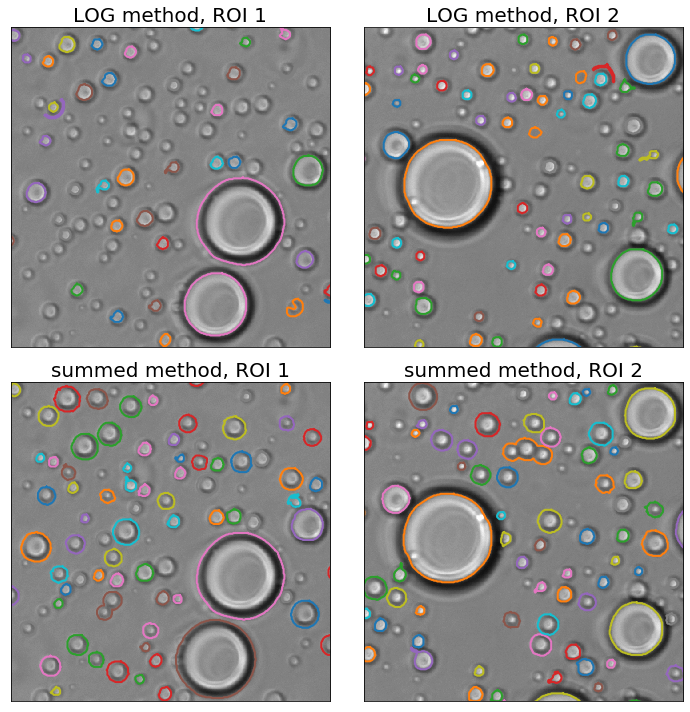

In [14]:
fig = plt.figure(figsize=(10,10))

im = imread("test_images/test_image_2.tif")

thresh_ecc = .97
thresh_area = 50

##########################################
##             LOG method               ##
##########################################
Kernel = mk_LOG_kernel(3,1.5)
highpass_filtered = convolve(im, Kernel)
edges = canny(highpass_filtered, 4)
filled = ndi.binary_fill_holes(edges)
labels, _ = ndi.label(filled) 
detected = np.zeros_like(im)
for i in regionprops(labels):
    if i.eccentricity<thresh_ecc and i.area>thresh_area:
        for y,x in i.coords:
            detected[y,x] = 1

ax1 = fig.add_subplot(221)
ax1.imshow(im, cmap=plt.cm.gray)
contours = find_contours(detected, .1)
for n, contour in enumerate(contours):
    ax1.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax1.set_xlim(800,1200)
ax1.set_ylim(0,400)
ax1.set_title("LOG method, ROI 1", fontsize = 20)
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(222)
ax2.imshow(im, cmap=plt.cm.gray)
contours = find_contours(detected, .1)
for n, contour in enumerate(contours):
    ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax2.set_xlim(800,1200)
ax2.set_ylim(640,1040)
ax2.set_title("LOG method, ROI 2", fontsize = 20)
ax2.set_xticks([])
ax2.set_yticks([])

##########################################
##             SUM method               ##
########################################## 
summed_mask = np.zeros_like(im, dtype=bool)
for i in range(10):
    edges = canny(im, sigma=i)
    filled = ndi.binary_fill_holes(edges)
    labels, _ = ndi.label(filled)
    detect = np.zeros_like(im)
    for i in regionprops(labels):
        if i.eccentricity<thresh_ecc and i.area>thresh_area:
            for y,x in i.coords:
                detect[y,x] = 1
    summed_mask = np.logical_or(summed_mask, detect)
    
ax3 = fig.add_subplot(223)
ax3.imshow(im, cmap=plt.cm.gray)
contours = find_contours(summed_mask, .1)
for n, contour in enumerate(contours):
    ax3.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax3.set_xlim(800,1200)
ax3.set_ylim(0,400)
ax3.set_title("summed method, ROI 1", fontsize = 20)
ax3.set_xticks([])
ax3.set_yticks([])

ax4 = fig.add_subplot(224)
ax4.imshow(im, cmap=plt.cm.gray)
contours = find_contours(summed_mask, .1)
for n, contour in enumerate(contours):
    ax4.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax4.set_xlim(800,1200)
ax4.set_ylim(640,1040)
ax4.set_title("summed method, ROI 2", fontsize = 20)
ax4.set_xticks([])
ax4.set_yticks([])

plt.tight_layout()
plt.show()

Okay, so a closer look doesn't really help determine which of these methods is "better". The summed method clearly finds more droplets, but also more consistantly draws the edge on or outside of the dark ring on the small droplets and inside on the larger droplets. Whereas the LOG methods tends to draw less circular shapes more often. 

Moving forward, we decided to use a combination of fourier filtering and the summed method. However, the filtering has an unwanted effect on the edge detector at smaller value of sigma. So we are only using the fourier filtering at the top end of sigma values.



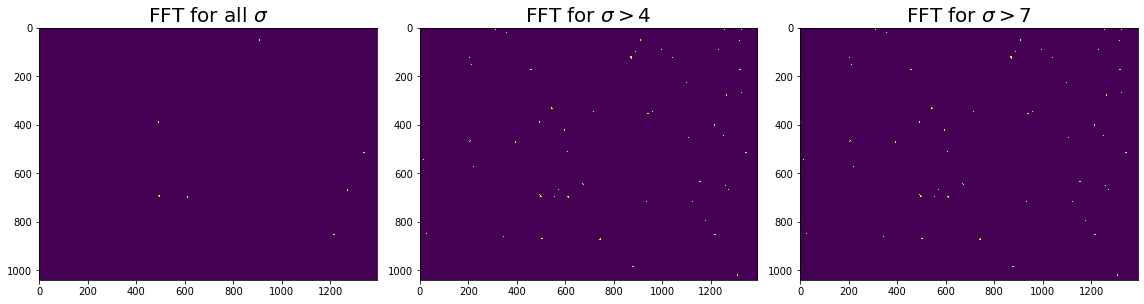

In [15]:
im = imread("test_images/test_image_5.tif")
im_new = highpass_fft(im, 150)

fig = plt.figure(figsize=(16,12))


start = time.time()
summed_mask = np.zeros_like(im_new, dtype=bool)
for i in range(11):
    edges = canny(im_new, sigma=i)
    filled = ndi.binary_fill_holes(edges)
    summed_mask = np.logical_or(summed_mask, filled)
end = time.time()
ax1 = fig.add_subplot(131)
ax1.set_title("FFT for all $\sigma$", fontsize = 20)
ax1.imshow(summed_mask)

summed_mask = np.zeros_like(im_new, dtype=bool)
for i in range(11):
    if i<=4:
        edges = canny(im, sigma=i)
    else:
        edges = canny(im_new, sigma=i)
    filled = ndi.binary_fill_holes(edges)
    summed_mask = np.logical_or(summed_mask, filled)
end = time.time()
ax2 = fig.add_subplot(132)
ax2.set_title("FFT for $\sigma > 4$", fontsize = 20)
ax2.imshow(summed_mask)

summed_mask = np.zeros_like(im_new, dtype=bool)
for i in range(11):
    if i<=7:
        edges = canny(im, sigma=i)
    else:
        edges = canny(im_new, sigma=i)
    filled = ndi.binary_fill_holes(edges)
    summed_mask = np.logical_or(summed_mask, filled)
end = time.time()
ax3 = fig.add_subplot(133)
ax3.set_title("FFT for $\sigma > 7$", fontsize = 20)
ax3.imshow(summed_mask)


plt.tight_layout()
plt.show()

Okay, so now we have to think about getting rid of non droplet blobs that are detected. We settled on using two different selection criteria: size thresholding and eccentricity thresholding. Size thresholding is pretty staightforward, i.e., we pick a size underwhich we no longer consider the object "real". [Eccentricity](https://en.wikipedia.org/wiki/Eccentricity_(mathematics) is defined as $\sqrt{1- \frac{b^2}{a^2}}$, where $a$ and $b$ are the major and minor axis lengths. A perfect circle has an eccentricity of $0$ and an elipse that is three times as long as it is fat has an eccentricity of $0.94$, which we will use as our cutoff. That said, there are cases when we get to larger substrate lengths, the HP1$\alpha$ droplets start to take on some wild shapes, we will return to this filter then to asses how well it captures those features.

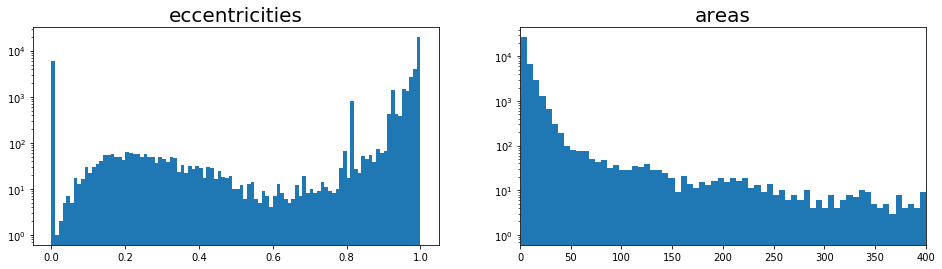

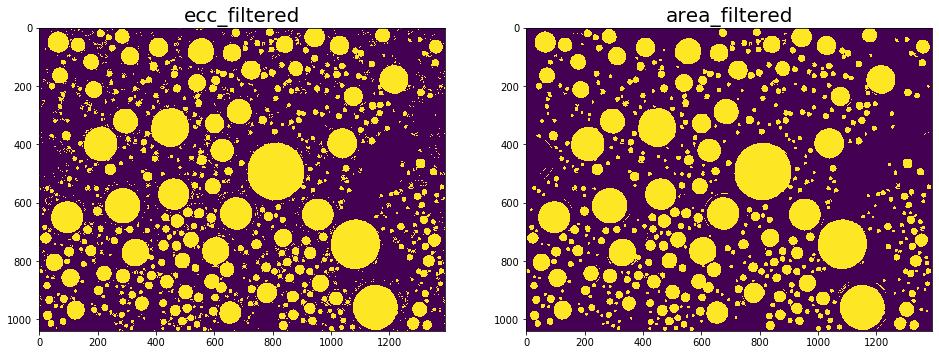

In [17]:
im = imread("test_images/test_image_1.tif")
im_new = highpass_fft(im, 150)
ecc_filtered = np.zeros_like(im)
area_filtered = np.zeros_like(im)
eccentricities = []
areas = []

for i in range(11):
    edges = canny(im, sigma=i)
    filled = ndi.binary_fill_holes(edges)
    labels, _ = ndi.label(filled)
    for j in regionprops(labels):
        if j.eccentricity<.94:
            for y,x in j.coords:
                ecc_filtered[y,x] = 1
        eccentricities.append(j.eccentricity)
        if j.area>50:
            for y,x in j.coords:
                area_filtered[y,x] = 1
        areas.append(j.area)

            
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121)
ax1.set_title("eccentricities", fontsize = 20)
ax1.hist(eccentricities, 100, log=True)
ax2 = fig.add_subplot(122)
ax2.set_title("areas", fontsize = 20)
ax2.hist(areas, 5000, log=True)
ax2.set_xlim(0,400)
plt.show()

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
ax1.set_title("ecc_filtered", fontsize = 20)
ax1.imshow(ecc_filtered)
ax2 = fig.add_subplot(122)
ax2.set_title("area_filtered", fontsize = 20)
ax2.imshow(area_filtered)
plt.show()

Okay, here we are going to put it all together into a working definition, and try it out on two of the test images.

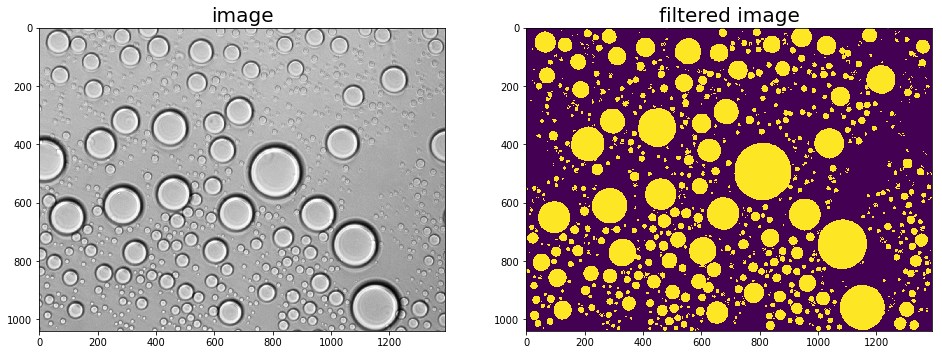

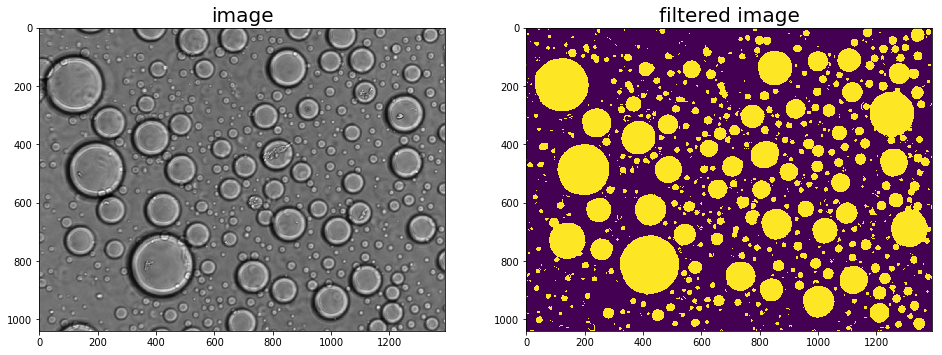

In [13]:
def mk_bf_segments(Image, fft = True, fft_thresh = 150, fft_cutoff = 7,
                   sumrange = 11, thresh_ecc = 0.94, thresh_area = 10):

    Image_new = highpass_fft(Image, fft_thresh)
    mask = np.zeros_like(Image, dtype=bool)
    for i in range(sumrange):
        if i<=fft_cutoff:
            edges = canny(Image, sigma=i)
        else:
            edges = canny(Image_new, sigma=i)
        filled = ndi.binary_fill_holes(edges)
        labels, _ = ndi.label(filled)
        detect = np.zeros_like(Image)
        for j in regionprops(labels):
            if j.eccentricity<thresh_ecc and j.area>thresh_area:
                for y,x in j.coords:
                    detect[y,x] = 1
        mask = np.logical_or(mask, detect)
        
    return mask


for im in [imread("test_images/test_image_1.tif"), 
           imread("test_images/test_image_4.tif")]:

    im_seg = mk_bf_segments(im)

    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(121)
    ax1.set_title("image", fontsize = 20)
    ax1.imshow(im, cmap = "Greys_r")
    ax2 = fig.add_subplot(122)
    ax2.set_title("filtered image", fontsize = 20)
    ax2.imshow(im_seg)

plt.show()



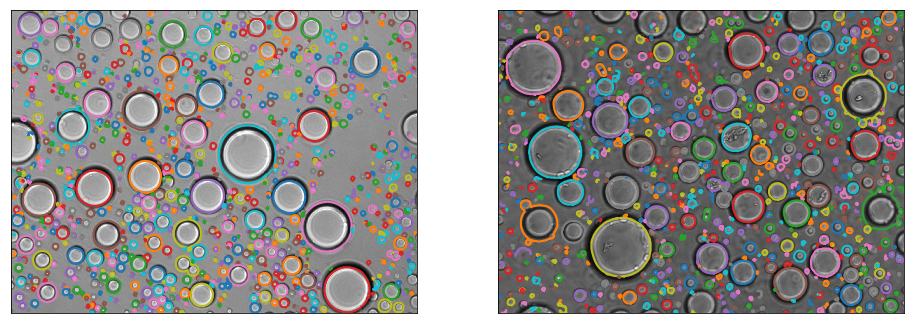

In [14]:
fig = plt.figure(figsize=(16,8))

im = imread("test_images/test_image_1.tif")
im_seg = mk_bf_segments(im)
ax1 = fig.add_subplot(121)
ax1.imshow(im, cmap=plt.cm.gray)
contours = find_contours(im_seg, .1)
for n, contour in enumerate(contours):
    ax1.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax1.set_xticks([])
ax1.set_yticks([])
im = imread("test_images/test_image_4.tif")
im_seg = mk_bf_segments(im)
ax2 = fig.add_subplot(122)
ax2.imshow(im, cmap=plt.cm.gray)
contours = find_contours(im_seg, .1)
for n, contour in enumerate(contours):
    ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

Also as we saw above, the sum method sometiomes combines multiple droplets into single entities, however, we do not feel the frequency and cases in which this occurs merits much concern, and we will use handle further segmentation of those combined droplets below.

## Special cases

#### Small droplets
----

We have a few conditions that exhibit fine scale droplets that in order to detect, requires setting the area threshold lower. Unfortunately, doing this results in a substantial amount of included noise. Therefore we switched between eccentricity thresholds for two different size regimes. That is, for smaller things we require them to be more circular ($\approx 15\%$ difference between the two axes of the droplet), while larger droplets can take on less circular geometries. 

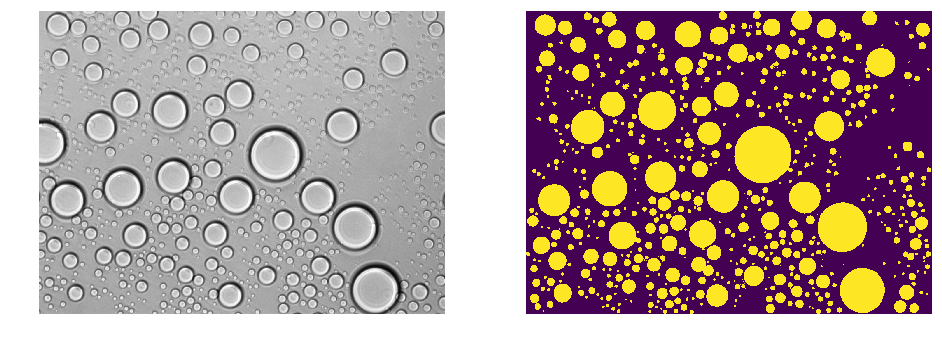

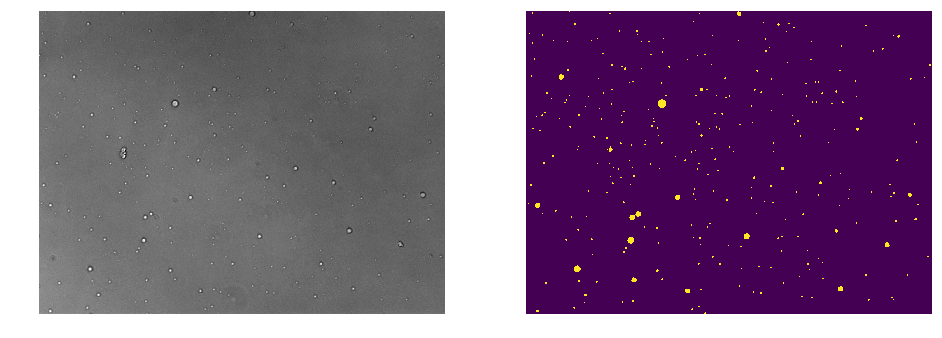

In [20]:
def mk_bf_segments(Image, fft = True, fft_thresh = 150, fft_cutoff = 7,
                   sumrange = 11, thresh_ecc = 0.94, thresh_area = 100, 
                   thresh_ecc_small = .5, thresh_area_small = 10):

    Image_new = highpass_fft(Image, fft_thresh)
    mask = np.zeros_like(Image, dtype=bool)
    
    for i in range(sumrange):
        if i<=fft_cutoff:
            edges = canny(Image, sigma=i)
        else:
            edges = canny(Image_new, sigma=i)

        filled = ndi.binary_fill_holes(edges)
        labels, _ = ndi.label(filled)
        detect = np.zeros_like(Image)
        
        for i in regionprops(labels):
            if i.eccentricity<thresh_ecc and i.area>thresh_area:
                for y,x in i.coords:
                    detect[y,x] = 1
            elif (i.eccentricity<thresh_ecc_small and i.area>thresh_area_small
                  and i.area<=thresh_area):
                for y,x in i.coords:
                    detect[y,x] = 1
        
        mask = np.logical_or(mask, detect)
        
    return mask

for im in [imread("test_images/test_image_1.tif"),
           imread("test_images/test_image_3.tif")]:

    im_seg = mk_bf_segments(im)
    labels, _ = ndi.label(im_seg) 

    fig = plt.figure(figsize=(16,8))

    ax1 = fig.add_subplot(121)
    ax1.imshow(im, cmap = "Greys_r")
    ax2 = fig.add_subplot(122)
    ax2.imshow(im_seg)
    ax1.axis('off')
    ax2.axis('off')


plt.show()

#### Empty images
----

We have also have conditions in which no phases form. Ideally, our algorithm will not find droplets in these images. There is of course a few false positives, but compared to images with small droplets, the method seems to work quite well

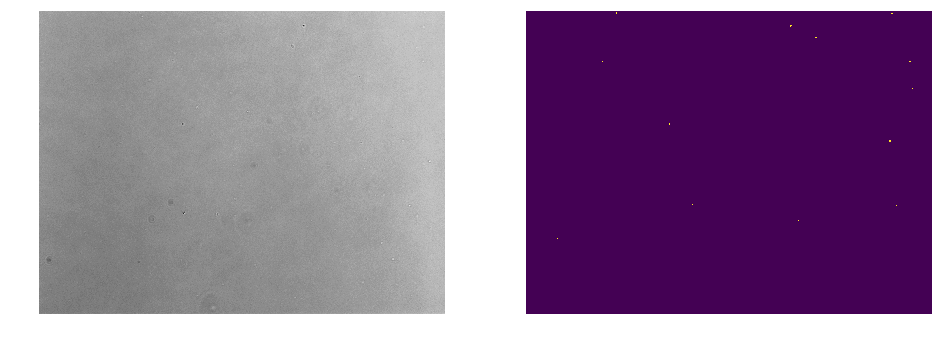

In [16]:
im = imread("test_images/test_image_5.tif")

im_seg = mk_bf_segments(im)

fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(121)
ax1.imshow(im, cmap = "Greys_r")
ax2 = fig.add_subplot(122)
ax2.imshow(im_seg)
ax1.axis('off')
ax2.axis('off')


plt.show()

#### Merged droplets
----

Also as we saw above, the sum method sometiomes combines multiple droplets into single entities. We use a watershed method to further separate those segments when possible. The remaining un-separated droplets, we feel, are insignificant enough to disregard.

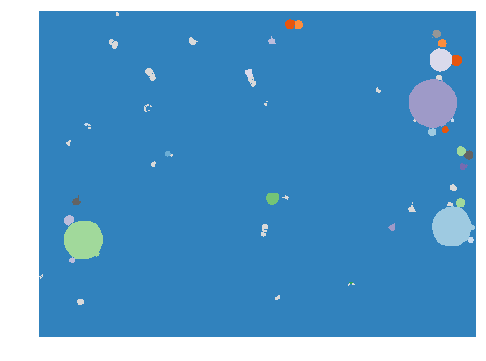

In [28]:
from skimage.morphology import watershed
import random

im = imread("test_images/test_image_4.tif")
im_seg = mk_bf_segments(im)


distance = distance_transform_edt(im_seg)
maxima = np.zeros_like(distance)        
for x,y in find_maxima(distance, 7, threshold_method = "threshold_mean"):
    maxima[y,x] = 1
labels, _ = ndi.label(maxima) 

mask_labels, _ = ndi.label(im_seg)
ws_mask = np.zeros_like(mask_labels)
output_mask = np.zeros_like(mask_labels)

for i in regionprops(mask_labels):
    
    rp = i.perimeter/(2*np.pi)
    ra = np.sqrt(i.area/np.pi)
    percent_diff = abs(rp-ra)*2/(rp+ra)
    if percent_diff>.1 and i.area>100:
        for y,x in i.coords:
            ws_mask[y,x] = 1

labels_ws = watershed(-distance, labels, mask=ws_mask, 
                      watershed_line=True)


detect = np.zeros_like(im)
for i in regionprops(labels_ws):
    val = random.randint(10,200)
    if i.area >1 and i.eccentricity<.5:
        for y,x in i.coords:
            detect[y,x] = val
    elif i.area >1 and i.eccentricity>.5:
        for y,x in i.coords:
            detect[y,x] = 1000

fig = plt.figure(figsize=(8,6))
plt.imshow(detect, cmap = "tab20c")
plt.axis('off')
plt.show()

## Segmented test images
----

In [34]:
def mk_bf_segments(Image, fft_thresh = 150, fft_cutoff = 7,
                   sumrange = 11, thresh_ecc = 0.94, thresh_area = 100, 
                   thresh_ecc_small = .5, thresh_area_small = 10, 
                   thresh_diff = .1):

    Image_new = highpass_fft(Image, fft_thresh)
    mask = np.zeros_like(Image, dtype=bool)
    
    for i in range(sumrange):
        if i<=fft_cutoff:
            edges = canny(Image, sigma=i)
        else:
            edges = canny(Image_new, sigma=i)

        filled = ndi.binary_fill_holes(edges)
        labels, _ = ndi.label(filled)
        detect = np.zeros_like(Image)
        
        for j in regionprops(labels):
            if j.eccentricity<thresh_ecc and j.area>thresh_area:
                for y,x in j.coords:
                    detect[y,x] = 1
            elif (j.eccentricity<thresh_ecc_small and j.area>thresh_area_small
                  and j.area<=thresh_area):
                for y,x in j.coords:
                    detect[y,x] = 1
        
        mask = np.logical_or(mask, detect)
        
        
    #-- Watershed
    mask_labels, _ = ndi.label(mask)
    
    ws_mask = np.zeros_like(mask_labels)
    bg_mask = np.zeros_like(mask_labels)

    for i in regionprops(mask_labels):
        rp = i.perimeter/(2*np.pi)
        ra = np.sqrt(i.area/np.pi)
        percent_diff = abs(rp-ra)*2/(rp+ra)
        if percent_diff>thresh_diff and i.area>thresh_area:
            for y,x in i.coords:
                ws_mask[y,x] = 1
        else:
            for y,x in i.coords:
                bg_mask[y,x] = 1

    distance = distance_transform_edt(mask)
    maxima = np.zeros_like(distance)        
    for x,y in find_maxima(distance, 7, threshold_method = "threshold_mean"):
        maxima[y,x] = 1
    labels, _ = ndi.label(maxima) 
    labels_ws = watershed(-distance, labels, mask=ws_mask, 
                          watershed_line=True)
    labels_bg, _ = ndi.label(bg_mask) 
    
    
    labeled_output = np.zeros_like(mask_labels)
    label = 1
    for i in regionprops(labels_ws):
        if i.area >1 and i.eccentricity<thresh_ecc_small:
            for y,x in i.coords:
                labeled_output[y,x] = label
            label+=1
    for i in regionprops(labels_bg):
        for y,x in i.coords:
            labeled_output[y,x] = label
        label+=1

        
    return labeled_output

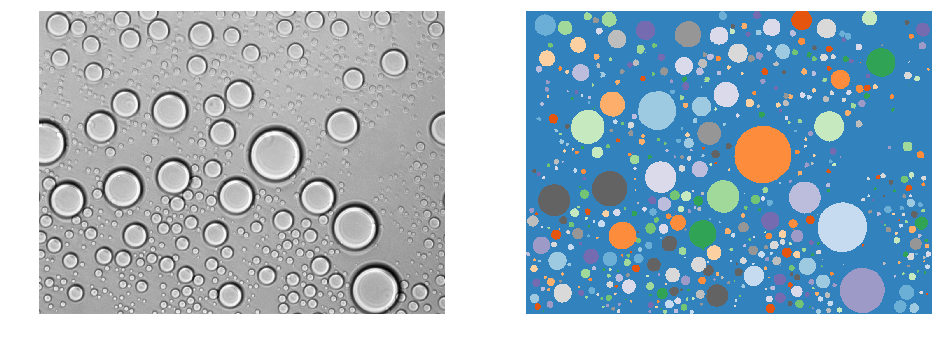

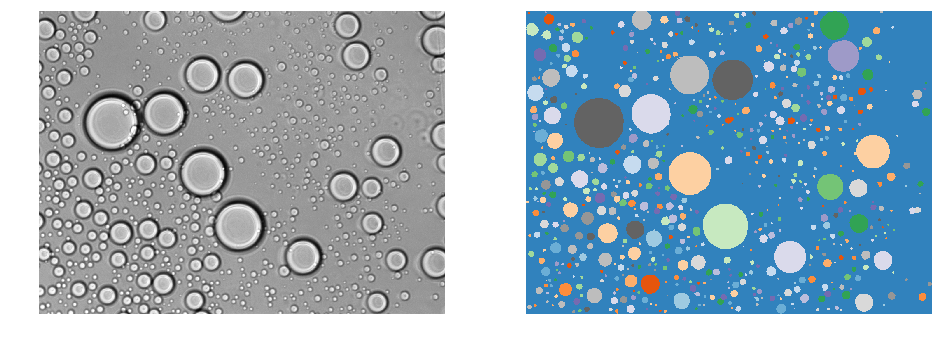

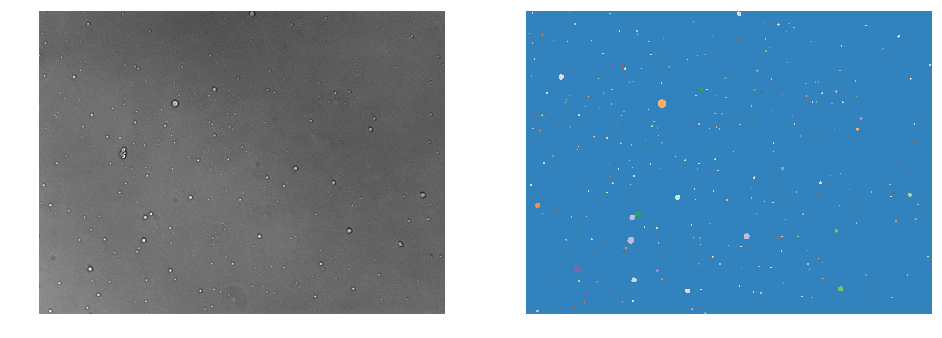

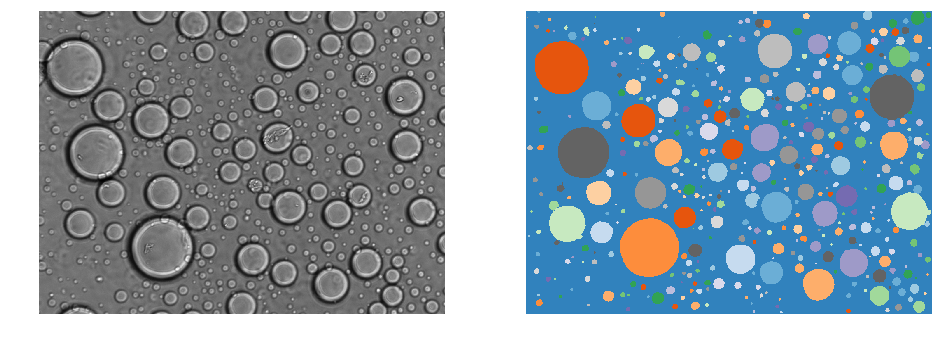

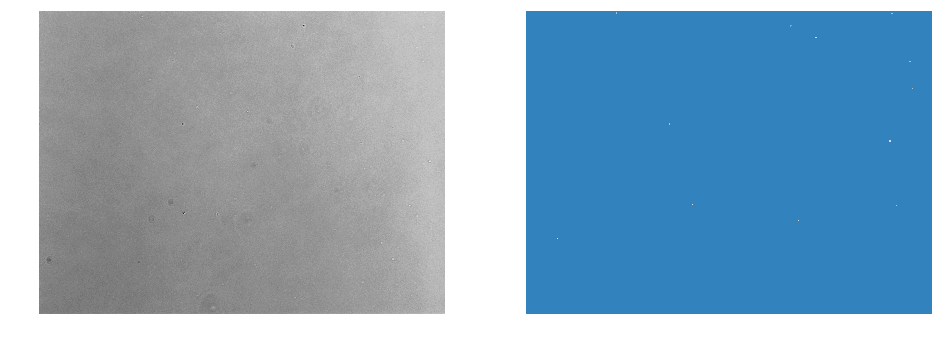

In [38]:
for im in [imread("test_images/test_image_1.tif"),
           imread("test_images/test_image_2.tif"),
           imread("test_images/test_image_3.tif"),
           imread("test_images/test_image_4.tif"),
           imread("test_images/test_image_5.tif")]:


    im_seg = mk_bf_segments(im)
    detected = np.zeros_like(im)
    for j in regionprops(im_seg):
        val = random.randint(10,200)
        for y,x in j.coords:
            detected[y,x] = val

    fig = plt.figure(figsize=(16,8))

    ax1 = fig.add_subplot(121)
    ax1.imshow(im, cmap = "Greys_r")
    ax2 = fig.add_subplot(122)
    ax2.imshow(detected, cmap = "tab20c")
    ax1.axis('off')
    ax2.axis('off')
        
plt.show()